In [1]:
# Loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from statistics import mean
from torch.autograd import Variable
import time
from PIL import Image
import random
from skimage import io, transform
from collections import OrderedDict
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from matplotlib import pyplot as plt
from skimage import io, transform
import skimage
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from collections import defaultdict 
import cv2
import matplotlib

In [2]:
# Remove wrong values in small image (due to interpolation)
def resize(img, height, width,
           interpolation=cv2.INTER_NEAREST):
    #use interpolation=cv2.INTER_CUBIC for image 
    """
    Resize an image using OpenCV.
    Note that cv2.resize dsize is (height, width).

    :param img: Input image
    :param height: height
    :param width: width
    :param interpolation: cv2 interpolation type
    :return: resized image
    """
    return cv2.resize(img, (height, width), interpolation=interpolation)

In [3]:
class ImageWithMaskDataset(Dataset):
    
    def __init__(self, csv_filePath, image_dir, mask_dir, transform=None):
        train_df = pd.read_csv(csv_file_path)
            
#         masks = os.listdir(mask_dir)
#         masks_df = pd.Series(masks).to_frame()
#         masks_df.columns = ['mask_file_name']
#         masks_df['image_id'] = masks_df.mask_file_name.apply(lambda x: x.split('_')[0])
#         train_df = pd.merge(train_df, masks_df, on='image_id', how='outer')
#         del masks_df
#         print(f"There are {len(train_df[train_df.mask_file_name.isna()])} images without a mask.")

#         ## removing items where image mask is null
#         train_df = train_df[~train_df.mask_file_name.isna()]        
        
#         images = os.listdir(image_dir)
#         images_df = pd.Series(images).to_frame()
#         images_df.columns = ['image_file_name']
#         images_df['image_id'] = images_df.image_file_name.apply(lambda x: x.split('.')[0])
#         train_df = pd.merge(train_df, images_df, on='image_id', how='outer')
#         del images_df 
#         print(f"There are {len(train_df[train_df.image_file_name.isna()])} image_ids without a image.")
        
#         ## Remove image_id not present in image_dir
#         train_df = train_df[~train_df.image_file_name.isna()]                
        
        ## Remove image_id not for Karolinska
        train_df = train_df[train_df.data_provider=='radboud']
        
        self.data_frame = train_df.copy()
        
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        print('Creating dataset with {} examples'.format(len(self.data_frame)))
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        
        image_id = self.data_frame.iloc[idx]['image_id']
        image_file_path = os.path.join(self.image_dir, image_id + ".tiff")
        image = skimage.io.MultiImage(image_file_path)[-1]
        
#         image = skimage.transform.resize(image, (224, 224))                
#         image = np.array(image)
        
#         image = transform.resize(image,(256,256))
        image = resize(image, 256,256,interpolation=cv2.INTER_CUBIC )
#         image = image / 255
        image = image.transpose((2, 0, 1))
        
        
        
        try:
            mask_file_path = os.path.join(self.mask_dir, image_id + "_mask.tiff")
            mask = skimage.io.MultiImage(mask_file_path)[-1]
            
            mask = resize(mask, 256,256)
            
#             mask = transform.resize(mask,(256,256))
#             mask = mask / 255
    #         print('mask shape', mask.shape)
            mask = mask.transpose((2, 0, 1))        
            mask = mask[0,:,:]
            
#         mask = np.expand_dims(mask,axis=-1).transpose((2, 0, 1))
        except:
            return None
                        
        isup_grade = self.data_frame.iloc[idx]['isup_grade']

        return (torch.from_numpy(image), torch.from_numpy(mask), isup_grade)

In [4]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [5]:
image_dir = '/project/data/train_images'
mask_dir = '/project/data/train_label_masks'
csv_file_path = '/home/abharani/data/train_filtered.csv'

# csv_file_path = '/kaggle/input/train-filtered/train_filtered.csv'
# # csv_file_path =  '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
# image_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_images'
# mask_dir = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks'


dataset_with_mask = ImageWithMaskDataset(csv_file_path, image_dir, mask_dir)

for i in range(len(dataset_with_mask)):
    sample = dataset_with_mask[i]
    print(i, sample[0].shape, sample[1].shape)
    
    if i == 2:
        plt.show()
        break

Creating dataset with 5060 examples
0 torch.Size([3, 256, 256]) torch.Size([256, 256])
1 torch.Size([3, 256, 256]) torch.Size([256, 256])
2 torch.Size([3, 256, 256]) torch.Size([256, 256])


In [6]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import pandas as pd
import os
import skimage 
from skimage import io 
import skimage.transform


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, WeightedRandomSampler
import torch.nn.functional as F
from torchvision import models

def train_val_dataset(dataset, val_split=0.25, generate_small=False):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets_created = {}
    if generate_small:
        print("Generating Small Train, Test Dataset")
        datasets_created['train'] = Subset(dataset, train_idx[0:200])
        datasets_created['test'] = Subset(dataset, val_idx[0:50])
    else:
        datasets_created['train'] = Subset(dataset, train_idx)
        datasets_created['test'] = Subset(dataset, val_idx)        
    return datasets_created



dataset_final = {}
datasets_created_trial_1 = train_val_dataset(dataset_with_mask,val_split=0.10,generate_small=True)
datasets_created_trial_2 = train_val_dataset(datasets_created_trial_1['train'],val_split=0.25,generate_small=True)

dataset_final['test'] = datasets_created_trial_1['test']
dataset_final['train'] = datasets_created_trial_2['train']
dataset_final['val'] = datasets_created_trial_2['test']

print("Dataset set size {}".format(len(dataset_with_mask)))
print("Train set size {}".format(len(dataset_final['train'])))
print("Validation set size {}".format(len(dataset_final['val'])))
print("Test set size {}".format(len(dataset_final['test'])))

Generating Small Train, Test Dataset
Generating Small Train, Test Dataset
Dataset set size 5060
Train set size 150
Validation set size 50
Test set size 50


In [7]:
count_dict = defaultdict(int)
target_list = []

#Generate target_list of all labels and count dict of all classes

for i, sample in enumerate(dataset_final['train']): 
    label = sample[2]
    count_dict[label] += 1
    target_list.append(int(label))
    
print("Distribution of classes: \n", count_dict)

class_count = [i for i in count_dict.values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print("Class weights : \n", class_weights)

target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
class_weights_all = class_weights[target_list]

weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

Distribution of classes: 
 defaultdict(<class 'int'>, {0.0: 26, 5.0: 38, 4.0: 16, 3.0: 28, 1.0: 23, 2.0: 19})
Class weights : 
 tensor([0.0385, 0.0263, 0.0625, 0.0357, 0.0435, 0.0526])


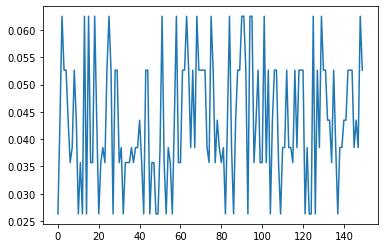

In [10]:
plt.plot(class_weights_all)

In [11]:
train_loader = DataLoader(dataset_final['train'],batch_size=32, collate_fn=collate_fn, sampler = weighted_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset_final['val'],batch_size=32, num_workers=4, collate_fn=collate_fn,pin_memory=True)

dataloaders  = {'train': train_loader, 'val': val_loader}

dataset_sizes = {x: len(dataset_final[x]) for x in dataset_final.keys()}

In [12]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    return np.squeeze(mask)

def plot_img(no_):
    iter_ = iter(train_loader)
    images,masks, _ = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    plt.figure(figsize=(20,10))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.imshow(image)
    for idx in range(0,no_):
         mask = mask_convert(masks[idx])
         plt.subplot(2,no_,idx+no_+1)
        
         plt.imshow(mask,cmap=cmap, interpolation='nearest',)
    plt.show()

In [13]:
# plot_img(1)

In [14]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=(3,3),padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,padding=padding,bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels,eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
     
        
class StackDecoder(nn.Module):
    def __init__(self,big_channel,channel1,channel2,kernel_size=(3,3),padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
            ConvBlock(channel2,channel2,kernel_size,padding),
        )
        
    def forward(self,x,down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  #combining channels of  input from encoder and upsampling input
            x = self.block(x)
            return x
        
        
class Unet256(nn.Module):
    def __init__(self,input_shape):
        super(Unet256,self).__init__()
        
        channel,height,width = input_shape
        
        self.down1 = StackEncoder(channel,12,kernel_size=(3,3))  #256
        self.down2 = StackEncoder(12,24,kernel_size=(3,3))  # 128
        self.down3 = StackEncoder(24,46,kernel_size=(3,3))  # 64
        self.down4 = StackEncoder(46,64,kernel_size=(3,3))  # 32
        self.down5 = StackEncoder(64,128,kernel_size=(3,3))  #16
        
        self.center = ConvBlock(128,128,kernel_size=(3,3),padding=1) #16
        
        self.up5 = StackDecoder(128,128,64,kernel_size=(3,3))  #32
        self.up4 = StackDecoder(64,64,46,kernel_size=(3,3)) #64
        self.up3 = StackDecoder(46,46,24,kernel_size=(3,3))
        self.up2 = StackDecoder(24,24,12,kernel_size=(3,3))
        self.up1 = StackDecoder(12,12,12,kernel_size=(3,3))
        self.conv = Conv2d(12,1,kernel_size=(1,1),bias=True)
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.conv(up1)


        return out
    

In [17]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/UNET256_1')


In [18]:
## Testing the model dry run

In [19]:
# x = torch.zeros((5, 3, 256, 256), dtype=torch.float32)  # minibatch size 64, image size [3, 32, 32]
# model = Unet256((3,256,256))
# scores = model(x)
# print(scores.size())  # you should see [5,1,256,256]


In [20]:
# from torchsummary import summary
model = Unet256((3,256,256)).to(device)
# model

In [21]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
#         print("Inside DiceBCELoss inputs : {} , targets: {}".format(inputs.shape, targets.shape))
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final

class NewDiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(NewDiceBCELoss, self).__init__()

#     def dice(pred, targs):
#         pred = (pred > 0).float()
#         return 2. * (pred * targs).sum() / (pred + targs).sum()
        
    def forward(self, inputs, targets, smooth=1):
               
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
#         inputs = (inputs > 0).float()
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
#         print("Inside DiceBCELoss inputs : {} , targets: {}".format(inputs.shape, targets.shape))
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
        
    

class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU * 100

    
    
class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score

In [22]:
# criterion = DiceBCELoss()
criterion = NewDiceBCELoss()


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
epochs = 25


train_loss = []
val_loss = []

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    
    for i, batch in enumerate(train_loader): 
            image,mask,_ = batch[0], batch[1], batch[2]
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            
            pred_mask = model.forward(image) # forward propogation
            
#             print("pred_mask : {}, mask : {} ".format(pred_mask.shape, mask.shape))
            loss = criterion(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
#             print("epoch {}, step {}".format(epoch, i))

            writer.add_graph(model, image)
                              

    else:           
        running_val_loss = []
        
        with torch.no_grad():
            for val_batch in val_loader:
                    v_image,v_mask,_ = val_batch[0], val_batch[1], val_batch[2]
#                     image = image.to(device,dtype=torch.float)
#                     mask = mask.to(device,dtype=torch.float)
                
                    v_image = v_image.to(device,dtype=torch.float)
                    v_mask = v_mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(v_image)
                    loss = criterion(pred_mask,v_mask)
                    running_val_loss.append(loss.item())
        
                    

                                    
    
    epoch_train_loss = np.mean(running_train_loss) 
    print('Train loss: {}'.format(epoch_train_loss))                       
    train_loss.append(epoch_train_loss)
    
    epoch_val_loss = np.mean(running_val_loss)
    print('Validation loss: {}'.format(epoch_val_loss))                                
    val_loss.append(epoch_val_loss)
                      
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/25


/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train loss: 0.5679870069026947
Validation loss: 0.4816235303878784
0m 19s
Epoch 2/25
Train loss: 0.4080377876758575
Validation loss: 0.4176590293645859
0m 10s
Epoch 3/25
Train loss: 0.35608134865760804
Validation loss: 0.3944648206233978
0m 11s
Epoch 4/25
Train loss: 0.30841628313064573
Validation loss: 0.3770661801099777
0m 10s
Epoch 5/25
Train loss: 0.32193848490715027
Validation loss: 0.36131924390792847
0m 11s
Epoch 6/25
Train loss: 0.28594212532043456
Validation loss: 0.3461707830429077
0m 11s
Epoch 7/25
Train loss: 0.2562859445810318
Validation loss: 0.3338497281074524
0m 11s
Epoch 8/25
Train loss: 0.2631269067525864
Validation loss: 0.31800779700279236
0m 11s
Epoch 9/25
Train loss: 0.22155698239803315
Validation loss: 0.3051735758781433
0m 11s
Epoch 10/25
Train loss: 0.18328187465667725
Validation loss: 0.29403626918792725
0m 11s
Epoch 11/25
Train loss: 0.21837948858737946
Validation loss: 0.2792500630021095
0m 11s
Epoch 12/25
Train loss: 0.19847262501716614
Validation loss: 0.2

/opt/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[18, 0, 90, 218] (-0.7413564920425415 vs. -0.7413783669471741) and 12 other locations (0.00%)
  check_tolerance, _force_outplace, True, _module_class)


Train loss: 0.12905691415071488
Validation loss: 0.2397388219833374
0m 11s
Epoch 15/25
Train loss: 0.14580411165952684
Validation loss: 0.2239285483956337
0m 11s
Epoch 16/25
Train loss: 0.13692411482334138
Validation loss: 0.21324944496154785
0m 11s
Epoch 17/25
Train loss: 0.1351497232913971
Validation loss: 0.1992991343140602
0m 11s
Epoch 18/25
Train loss: 0.11978009790182113
Validation loss: 0.18461383879184723
0m 11s
Epoch 19/25
Train loss: 0.09308851957321167
Validation loss: 0.17186035215854645
0m 11s
Epoch 20/25
Train loss: 0.06010135188698769
Validation loss: 0.16066590324044228
0m 11s
Epoch 21/25
Train loss: 0.019787054508924484
Validation loss: 0.14777151495218277
0m 11s
Epoch 22/25
Train loss: 0.016091129183769225
Validation loss: 0.13373559340834618
0m 11s
Epoch 23/25
Train loss: 0.06616316288709641
Validation loss: 0.12240033224225044
0m 11s
Epoch 24/25
Train loss: 0.01861683577299118
Validation loss: 0.10997873544692993
0m 11s
Epoch 25/25
Train loss: 0.007391782104969024
V

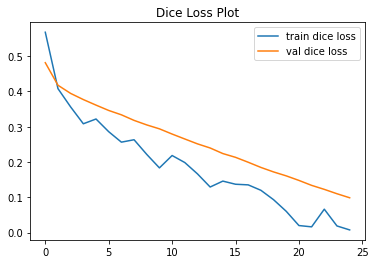

In [24]:
plt.plot(train_loss,label='train dice loss')
plt.plot(val_loss,label='val dice loss')
plt.legend()
plt.title('Dice Loss Plot')
plt.show()

In [25]:
torch.save(model.state_dict(), '/home/abharani/data/Unet256_v1_june_25')

In [26]:
# model = Unet256((3,256,256)).to(device)
# model.load_state_dict(torch.load('/home/abharani/data/Unet256_v1_epoch_10'))
# model.eval()

In [27]:
model.eval()   # Set model to evaluate mode

test_loader = DataLoader(dataset_final['test'],batch_size=32,  collate_fn=collate_fn,num_workers=4, pin_memory=True)

t_images, t_masks, t_isup_grade  = next(iter(test_loader))
t_images = t_images.to(device, dtype = torch.float32)
t_masks = t_masks.to(device, dtype = torch.float32)
# inputs = torch.reshape(inputs,(inputs.shape[0],inputs.shape[3],inputs.shape[1],inputs.shape[2])) #  inputs.reshape [N, C, W, H]
# labels = torch.reshape(labels,(labels.shape[0],labels.shape[3],labels.shape[1],labels.shape[2])) #  inputs.reshape [N, C, W, H]


t_preds = model(t_images)
t_preds = t_preds.to(device)
# pred = torch.sigmoid(pred) # it will convert to 0 and 1 never do for multi class
# pred = pred.data.cpu().numpy()
print(t_preds.shape)

torch.Size([32, 1, 256, 256])


In [28]:
print(torch.unique(t_preds[0]))
print(torch.unique(t_masks[0]))

tensor([-1.6019, -1.6000, -1.5983,  ...,  8.9744,  9.1408,  9.1863],
       device='cuda:0', grad_fn=<NotImplemented>)
tensor([0., 1., 2., 4.], device='cuda:0')


In [29]:

print(len(torch.unique(t_preds[0])))

# x = torch.max(x,torch.tensor([0.]))

print(torch.unique(t_masks[0]))

59007
tensor([0., 1., 2., 4.], device='cuda:0')


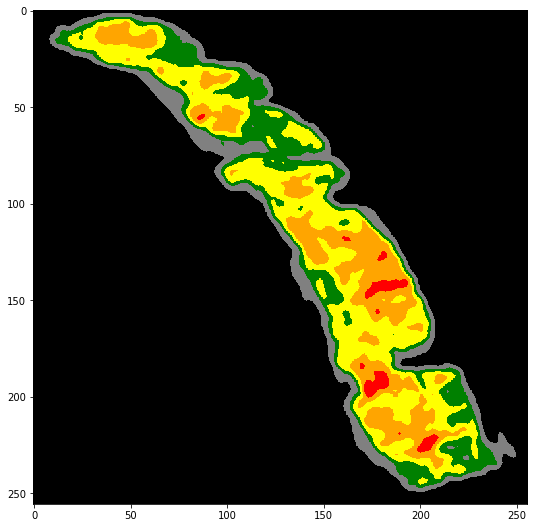

In [30]:
cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
plt.figure(figsize=(20,20))
plt.title("Predict Mask")
no_ = 1
for idx in range(0,no_):
#      torch.nn.functional.relu(t_preds[idx], inplace=True)
     t_pred = mask_convert(t_preds[idx])
     plt.subplot(2,no_,idx+no_+1)
     plt.imshow(t_pred,cmap=cmap)

plt.show()        

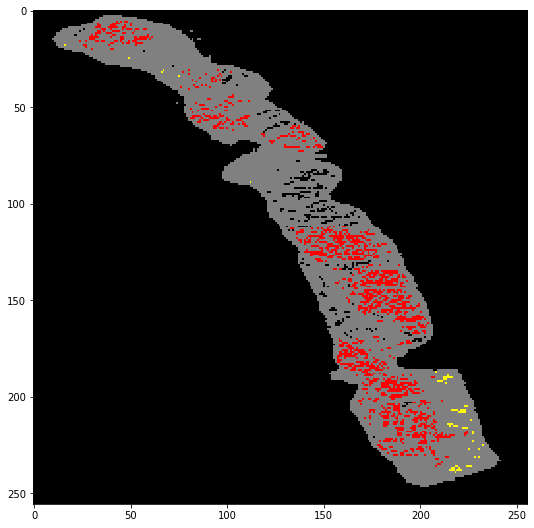

In [31]:
plt.figure(figsize=(20,20))
for idx in range(0,no_):
     t_mask = mask_convert(t_masks[idx])
     plt.subplot(2,no_,idx+no_+1)
     plt.imshow(t_mask,cmap=cmap, interpolation='nearest',)  
plt.show()

In [32]:
def plot_test_results(t_images, t_preds, t_masks, isup_grade, i) :
    """ t_preds : predicted masks output N, classes, 224, 224
        t_masks : input masks N, clasees, 224, 224 
        isup_grader : N
        i : image number to plot
    """ 
        
    input_image_i = t_images[i,:,:,:]
    predicted_mask_i = t_preds[i].squeeze()
    original_mask_i  = t_masks[i]
#     predicted_mask_i = torch.argmax(t_preds[i], dim=0)
#     original_mask_i = torch.argmax(t_masks[i], dim=0)
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    cmap_p = matplotlib.colors.ListedColormap(['black', 'black', 'yellow','orange', 'red'])

    fig = plt.figure(figsize=(20, 20))
#     plt.title("Test Results")

    # ============ AX1 ============ 
    ax1 = fig.add_subplot(3, 3, 1)
    ax1.set_title("Input Image with isup grade {}".format(isup_grade[i]))
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(image_convert(input_image_i).astype('uint8'))   


    # ============ AX2 ============ 
    ax2 = fig.add_subplot(3, 3, 2)
    ax2.set_title("Original Mask")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.imshow(original_mask_i.clone().cpu().numpy(),cmap=cmap, interpolation='nearest')


    # ============ AX3 ============ 
    ax3 = fig.add_subplot(3, 3, 3)
    ax3.set_title("Predicted Mask")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.imshow(predicted_mask_i.clone().cpu().detach().numpy(),cmap=cmap_p)   
    


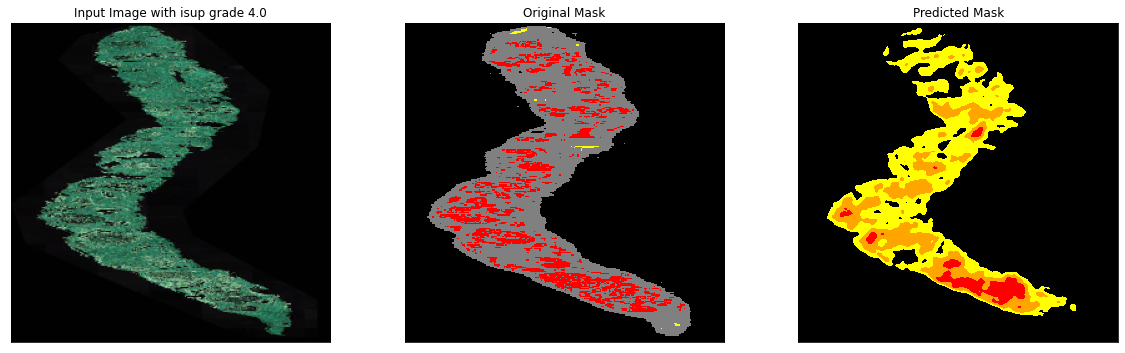

In [37]:
plot_test_results(t_images, t_preds, t_masks, t_isup_grade,10)

In [43]:
image_dir
def read_image(image_path):
    image = skimage.io.MultiImage(image_path)[-1]
    resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_NEAREST)
    return resized_image

In [44]:
def gleason_distribution(mask_image):
    
    """ input mask with shape as h,w,c 
    """
    gleason0_count = (mask_image[:,:,0]== 0).sum()
    gleason1_count = (mask_image[:,:,0]== 1).sum()
    gleason3_count = (mask_image[:,:,0]== 3).sum()
    gleason4_count = (mask_image[:,:,0]== 4).sum()
    gleason5_count = (mask_image[:,:,0]== 5).sum()
    
    total_pixels = gleason3_count + gleason4_count + gleason5_count
    #mask_image.shape[0] * mask_image.shape[1] - gleason0_count -gleason2_count - gleason1_count # non-tissue
    gleason3_per = 100. * gleason3_count /total_pixels 
    gleason4_per = 100. * gleason4_count /total_pixels
    gleason5_per = 100. * gleason5_count /total_pixels
    
    gleason_dict = {3:gleason3_per,4:gleason4_per, 5:gleason5_per}
    scores = sorted(gleason_dict, key=gleason_dict.get, reverse=True)
#     print(scores[:2])
    calculated_gleason_score =  "+".join(str(i) for i in scores[:2])
#     print(calculated_gleason_score)
#     return gleason3_per, gleason4_per, gleason5_per,calculated_gleason_score
    return calculated_gleason_score

sample_tiff_file = os.path.join(image_dir,'5c90deb93f9fd965642b6edda6561bde.tiff')
sample_mask_file = os.path.join(mask_dir,'5c90deb93f9fd965642b6edda6561bde_mask.tiff')
sample_image = read_image(sample_tiff_file)
sample_mask = read_image(sample_mask_file)

print(gleason_distribution(sample_mask))

gleason0_count = (sample_mask[:,:,0]== 0).sum()
gleason1_count = (sample_mask[:,:,0]== 1).sum()
gleason2_count = (sample_mask[:,:,0]== 2).sum()
gleason3_count = (sample_mask[:,:,0]== 3).sum()
gleason4_count = (sample_mask[:,:,0]== 4).sum()
gleason5_count = (sample_mask[:,:,0]== 5).sum()



print("Glean Score 0 count {} ".format(gleason0_count))
print("Glean Score 1 count {} ".format(gleason1_count))
print("Glean Score 2 count {} ".format(gleason2_count))
print("Glean Score 3 count {} ".format(gleason3_count))
print("Glean Score 4 count {} ".format(gleason4_count))
print("Glean Score 5 count {} ".format(gleason5_count))

3+4
Glean Score 0 count 56884 
Glean Score 1 count 7788 
Glean Score 2 count 809 
Glean Score 3 count 55 
Glean Score 4 count 0 
Glean Score 5 count 0 


In [45]:
train_df = pd.read_csv(csv_file_path)
train_df[train_df['image_id']=='5c90deb93f9fd965642b6edda6561bde']

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,mask_file_name,image_file_name
3687,3687,5c90deb93f9fd965642b6edda6561bde,radboud,2.0,3+4,5c90deb93f9fd965642b6edda6561bde_mask.tiff,5c90deb93f9fd965642b6edda6561bde.tiff


RuntimeError: shape '[1, 2, 0]' is invalid for input of size 65536